<a href="https://colab.research.google.com/github/Shoitiro/samurai-terakoya/blob/main/retirement_k_fold%2BLightGBM%2BSMOTE(0_8250000).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

%matplotlib inline

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 856.9 kB/s eta 0:00:00


In [15]:
# idを削除
train_del = train_df.drop(["id"], axis = 1)
test_del = test_df.drop(["id"], axis = 1)

# 学習用データの特徴量を選択
X_train = train_df[['DailyRate', 'DistanceFromHome']]

# テスト用データの特徴量を選択
X_test = test_df[['DailyRate', 'DistanceFromHome']]

# StandardScalerのインスタンスを作成
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 学習用データを標準化
X_train_scaled = scaler.fit_transform(X_train)

# テスト用データを標準化
X_test_scaled = scaler.transform(X_test)

# 標準化したカラムを元のデータセットに代入
train_del[['DailyRate', 'DistanceFromHome']] = X_train_scaled
test_del[['DailyRate', 'DistanceFromHome']] = X_test_scaled

train_del

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,26,Travel_Rarely,-0.722009,Research & Development,-0.321903,3,Medical,4,Male,43,...,80,0,1,3,2,11,8,7,0,0
1,47,Travel_Rarely,-0.049412,Research & Development,2.031927,3,Technical Degree,2,Male,98,...,80,1,20,1,1,5,9,4,4,0
2,26,Travel_Rarely,0.799055,Human Resources,-0.349740,3,Life Sciences,2,Male,84,...,80,1,4,3,3,3,2,0,2,0
3,46,Travel_Rarely,-0.107181,Research & Development,0.562431,1,Medical,1,Female,79,...,80,1,6,0,1,5,4,7,7,1
4,25,Travel_Rarely,-0.602395,Research & Development,-0.992703,4,Medical,2,Male,98,...,80,1,8,3,3,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,49,Travel_Rarely,0.526186,Research & Development,0.372068,2,Medical,4,Male,67,...,80,0,33,3,2,3,2,1,2,0
1196,37,Travel_Frequently,-0.753318,Research & Development,-0.969031,1,Other,4,Male,82,...,80,0,6,5,2,9,2,0,8,0
1197,40,Non-Travel,0.549381,Human Resources,-0.000419,3,Life Sciences,3,Male,40,...,80,1,19,2,3,14,9,9,9,0
1198,37,Travel_Frequently,-1.397381,Sales,-0.932079,2,Marketing,1,Male,93,...,80,2,6,5,3,3,2,0,3,0


In [16]:
test_del

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,34,Travel_Frequently,-0.945737,Research & Development,-0.035856,3,Life Sciences,1,Female,73,...,3,80,1,11,2,3,7,7,2,7
1,37,Travel_Rarely,-0.003317,Research & Development,0.021348,3,Medical,1,Male,78,...,4,80,0,5,3,2,1,3,1,0
2,34,Travel_Frequently,0.500256,Research & Development,-0.851257,3,Life Sciences,2,Female,73,...,3,80,1,21,2,2,4,3,1,4
3,34,Travel_Rarely,-1.617298,Research & Development,-0.957888,4,Medical,3,Female,53,...,4,80,3,9,3,3,20,6,1,4
4,29,Travel_Rarely,0.463427,Research & Development,-0.024750,2,Life Sciences,3,Male,77,...,3,80,1,25,2,4,1,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,26,Travel_Rarely,1.655012,Research & Development,-1.095347,3,Medical,1,Male,84,...,4,80,1,1,3,3,13,10,5,13
796,25,Travel_Rarely,-0.731998,Research & Development,-0.407389,4,Medical,1,Female,40,...,3,80,0,6,5,2,5,4,0,4
797,26,Travel_Frequently,-1.572841,Research & Development,0.062955,3,Medical,3,Male,37,...,2,80,0,9,2,3,5,4,1,4
798,25,Travel_Frequently,-1.641207,Research & Development,-1.148655,3,Other,2,Female,85,...,2,80,2,5,3,3,5,0,0,0


In [7]:
# "BusinessTravel","Department","JobRole"をエンコーダで処理
encoding = ce.OrdinalEncoder(["BusinessTravel","Department","JobRole"])

# 前処理用目的変数"Attrition"を落とす
train_trans = encoding.fit_transform(train_del.drop(["Attrition"], axis = 1))
test_trans = encoding.transform(test_del)

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
oversampling = SMOTE()
X_sample, y_sample = oversampling.fit_resample(train_trans, train_del["Attrition"])
X_sample

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,26,1,-0.722009,1,-0.321903,3,1,4,1,43,...,3,80,0,1,3,2,11,8,7,0
1,47,1,-0.049412,1,2.031927,3,2,2,1,98,...,3,80,1,20,1,1,5,9,4,4
2,26,1,0.799055,2,-0.349740,3,3,2,1,84,...,2,80,1,4,3,3,3,2,0,2
3,46,1,-0.107181,1,0.562431,1,1,1,2,79,...,4,80,1,6,0,1,5,4,7,7
4,25,1,-0.602395,1,-0.992703,4,1,2,1,98,...,2,80,1,8,3,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,25,1,-0.747164,1,-0.475088,2,3,2,1,72,...,3,80,1,2,1,3,1,0,0,0
1970,19,1,-0.759343,3,0.045336,3,4,2,2,75,...,1,80,0,2,2,3,2,6,0,1
1971,29,2,-0.096190,3,-0.760922,2,3,1,1,87,...,3,80,0,16,3,2,1,0,0,0
1972,17,1,1.309786,1,1.418402,1,2,2,2,66,...,4,80,1,4,1,2,4,0,0,2


(array([987.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 987.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

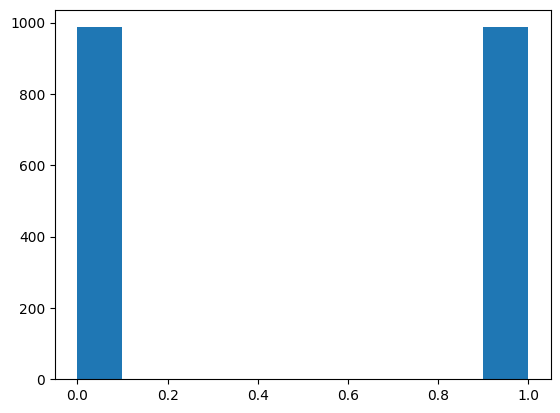

In [10]:
plt.hist(y_sample)

In [11]:
# X,yの定義づけ
#X = train_trans
#y = train_df["charges"]

X = X_sample
y = y_sample

import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold



FOLD = 5  # 分割数
NUM_ROUND = 100  # LightGBMのラウンド数
VERBOSE_EVAL = -1

params = {
    'objective': 'multiclass',  # 多クラス分類
    'num_class': 2,  # クラスの数（例えば2段階の予測の場合）
    'metric': 'multi_logloss'  # 損失関数にmulti_loglossを使用
}

valid_scores = []
models = []
kf = KFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
    X_train, X_valid = X.loc[train_indices], X.loc[valid_indices]
    y_train, y_valid = y.loc[train_indices], y.loc[valid_indices]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=NUM_ROUND
    )

    y_valid_pred = np.argmax(model.predict(X_valid), axis=1)
    score = f1_score(y_valid, y_valid_pred, average="macro")
    print(f'fold {fold} f1: {score}')

    valid_scores.append(score)
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 1579, number of used features: 29
[LightGBM] [Info] Start training from score -0.692514
[LightGBM] [Info] Start training from score -0.693781
fold 0 f1: 0.8961785766945106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 1579, number of used features: 29
[LightGBM] [Info] Start training from score -0.687464
[LightGBM] [Info] Start training from score -0.698863
fold 1 f1: 0.8987023644663281
[LightGBM] [Info] Au

In [12]:
valid_scores

[0.8961785766945106,
 0.8987023644663281,
 0.9215109384714986,
 0.9030361757105942,
 0.9004760516856116]

In [13]:
print(y_valid_pred)

[0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [14]:
y_valid_pred.shape

(394,)

In [17]:
# モデルの学習
best_model = models[np.argmax(valid_scores)]

# テストデータで目的変数を予測
y_test_pred = np.argmax(best_model.predict(test_trans), axis=1)

y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,

In [18]:
y_test_pred.shape

(800,)

In [19]:
# データ結合
df_predicted = pd.concat([test_df["id"], pd.DataFrame(data = y_test_pred, columns=["Predicted_value"])], axis=1)
df_predicted["Predicted_value"] = df_predicted["Predicted_value"].round().astype(int)

# CSVファイルに出力
df_predicted.to_csv('retirement_k-fold_LightGBM_SMOTE.csv', index=False)